In [33]:
import sys
import os
sys.path.append("/usr/local/lmod/lmod/init")
import matplotlib.pyplot as plt
import numpy as np

import smartredis
from driver import mom6_clustered_driver
from env_modules_python import module

In [2]:
module('load','smartredis/gcc-9.3.0/0.3.0','cudatoolkit/11.2.0_3.39-7.0.3.0_2.1__gf93aa1c','cudnn/8.2.0')
ld_library_path = os.environ['LD_LIBRARY_PATH']
os.environ['LD_LIBRARY_PATH'] = f'{ld_library_path}:/usr/local/cuda-11.2/lib64'

In [3]:
experiment, mom_ensemble, orchestrator = mom6_clustered_driver(
    walltime="02:00:00",
    ensemble_size=1,
    nodes_per_member=25,
    tasks_per_node=45,
    mom6_exe_path="/lus/cls01029/shao/dev/gfdl/MOM6-examples/build/gnu/"+
                  "ice_ocean_SIS2/repro/MOM6",
    ensemble_node_features='[CL48|SK48|SK56]',
    mask_table="mask_table.315.32x45",
    domain_layout="32,45",
    eke_model_name="ncar_ml_eke.gpu.pt",
    eke_backend="GPU",
    orchestrator_port=6780,
    orchestrator_interface="ipogif0",
    orchestrator_nodes=3,
    orchestrator_node_features='P100',
    configure_only=True
)


12:17:24 horizon SmartSim[26125] INFO Working in previously created experiment


In [4]:
experiment.start(mom_ensemble, orchestrator, block=False)

12:17:34 horizon SmartSim[26125] INFO Orchestrator launched as a batch
12:17:34 horizon SmartSim[26125] INFO While queued, SmartSim will wait for Orchestrator to run
12:17:34 horizon SmartSim[26125] INFO CTRL+C interrupt to abort and cancel launch
12:18:02 horizon SmartSim[26125] INFO Database cluster created with 3 shards


In [5]:
orchestrator.get_address()

['10.128.0.153:6780', '10.128.0.155:6780', '10.128.0.154:6780']

In [6]:
client = smartredis.Client(orchestrator.get_address()[0],True)

In [39]:

def retrieve_all_ranks(client, ensemble_id, key_basename, nranks, dtype="float64"):
    retrieve_d = {}
    for rank in range(nranks):
        rank_id= f'{rank:06d}'
        key = f'{ensemble_id}.{key_basename}_{rank_id}'
        retrieve_d[rank_id] = client.get_tensor(key)
    return retrieve_d


def reconstruct_domain(client, ensemble_id, key_basename, timestamp, nranks):
    """Reconstruct the domain of MOM6 by rank"""
    import time
    start_iter = time.time()
    

    meta_rank = retrieve_all_ranks(client, ensemble_id, f"meta" ,nranks)
    starti_rank  = np.array([int(meta[0]) for meta in meta_rank.values()])
    startj_rank  = np.array([int(meta[2]) for meta in meta_rank.values()])
    glob_starti_rank = starti_rank - min(starti_rank)
    glob_startj_rank = startj_rank - min(startj_rank)

    t1 = time.time()
    h_rank = retrieve_all_ranks(client, ensemble_id, f'{key_basename}_{timestamp}.',nranks)

    ni_rank = np.array( [ h.shape[-1] for h in h_rank.values()] )
    nj_rank = np.array( [ h.shape[-2] for h in h_rank.values()] )
   
    glob_endi_rank = glob_starti_rank + ni_rank - 1
    glob_endj_rank = glob_startj_rank + nj_rank - 1

    ni_glob = max(glob_endi_rank) + 1
    nj_glob = max(glob_endj_rank) + 1
    
    h_glob = np.zeros([nj_glob,ni_glob])

    for rank in range(nranks):
        si = glob_starti_rank[rank]
        sj = glob_startj_rank[rank]
        ei = glob_endi_rank[rank]
        ej = glob_endj_rank[rank]

        h_glob[sj:ej,si:ei] = h_rank[f'{rank:06d}']
    iter_time = time.time() - start_iter
    print(f"Time elapsed in iteration: {iter_time}")

    return h_glob


In [40]:
ensemble_id = 'MOM_0'
key_basename = 'EKE'
timestamp1 = '59886871200'
timestamp2 = '59886878400'
nranks = 32*45-315
MKE1 = reconstruct_domain(client,ensemble_id,key_basename,timestamp1,nranks)


ValueError: could not broadcast input array from shape (53,32) into shape (50,29)

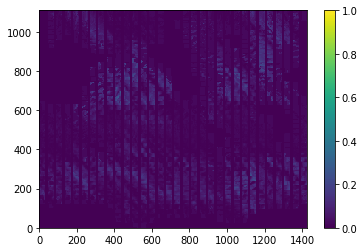

In [ ]:
plt.pcolormesh(MKE1,vmin=0.,vmax=1)
plt.colorbar()